Single Cell Transcriptomics (PBMC3k)
====================================

In [1]:
import scanpy as sc
import singleCellHaystack as hs

sc.set_figure_params(facecolor="white", dpi=90)

## Load data

We load the human PBMC data available from scanpy.

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/diez/miniconda3/envs/singleCellHaystack/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


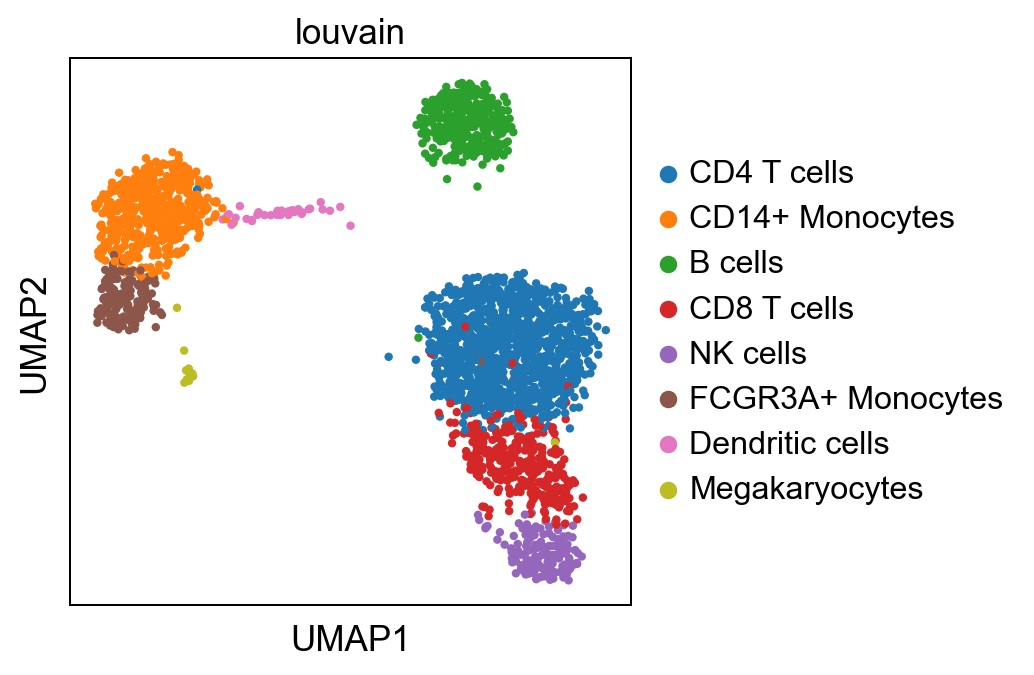

In [3]:
sc.pl.umap(adata, color="louvain")

## Filter some cells

We remove Megakaryocytes since they are not interesting in this example and they will drive the top results.

In [4]:
mega = adata.obs.louvain.isin(["Megakaryocytes"])
mega.value_counts()

False    2623
True       15
Name: louvain, dtype: int64

In [5]:
adata = adata[~mega, :]
adata

View of AnnData object with n_obs × n_vars = 2623 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Run haystack

We run `haystack` using PCA coordinates and otherwise default parameters. Since the data has been scaled, we need to pass the raw data to avoid negative numbers. Also this will allow `haystack` to run on all the genes, not only those to calculate the PCA coordinates.

In [6]:
res = hs.haystack(adata.raw.to_adata(), coord="pca")

> starting haystack ...
> entering array method ...
> scaling coordinates ...
> calculating feature stds ...
> removing 6 genes with zero variance ...
> calculating grid points ...
> calculating distance to cells ...
> calculating densities ...
> calculating Q dist ...
> calculating KLD for 13708 features ...


100%|██████████| 13708/13708 [00:02<00:00, 6130.26it/s]


> calculating feature's CV ...
> selecting genes to randomize ...
> calculating randomized KLD ...


100%|██████████| 100/100 [00:02<00:00, 40.36it/s]


> calculating P values ...
> done.


## Check some QC plots

We can examine some of the QC plots. First the randomization fits. These are used to calculate KLD from randomized expression levels for a subset of genes, in order to estimate the values to the entire gene set.

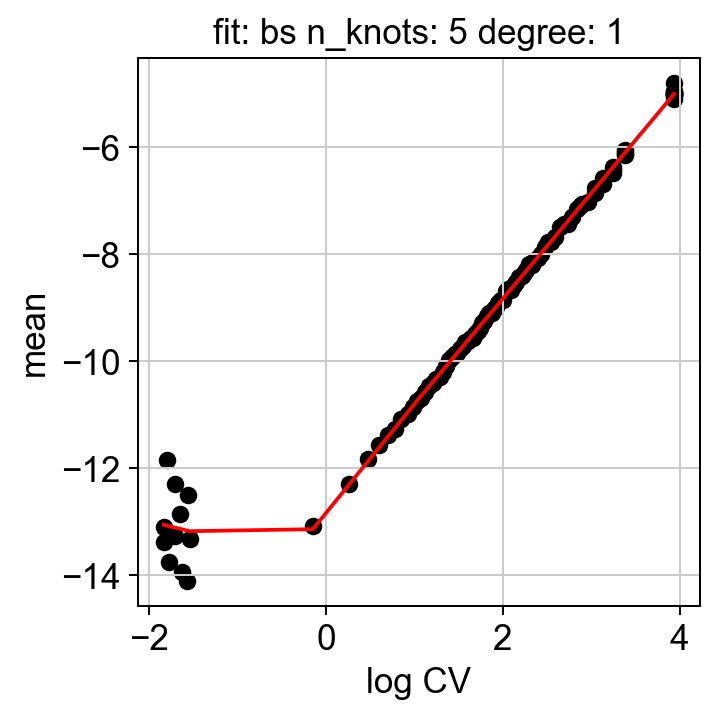

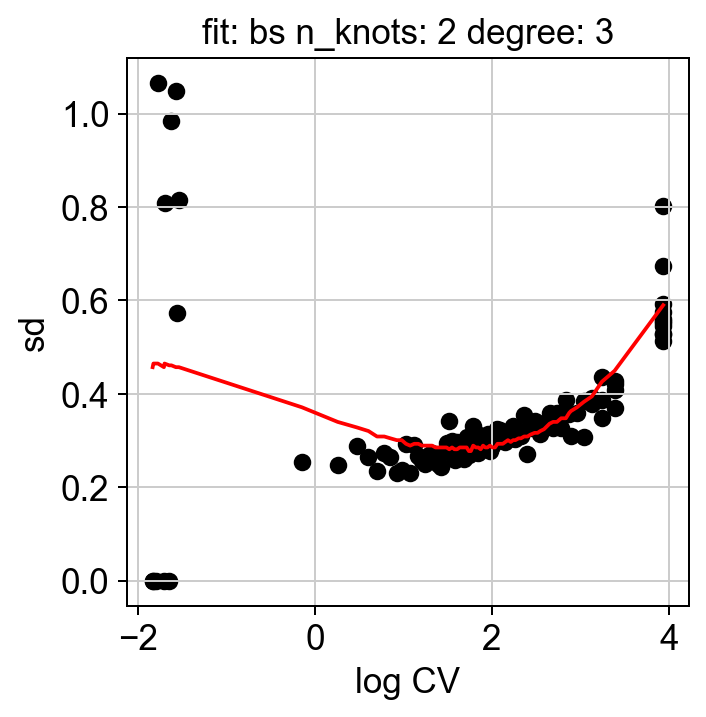

In [7]:
hs.plot_rand_fit(res, "mean")
hs.plot_rand_fit(res, "sd")

The ranking of logpval and distribution of pval gives us some idea of how many significant genes we can detect.

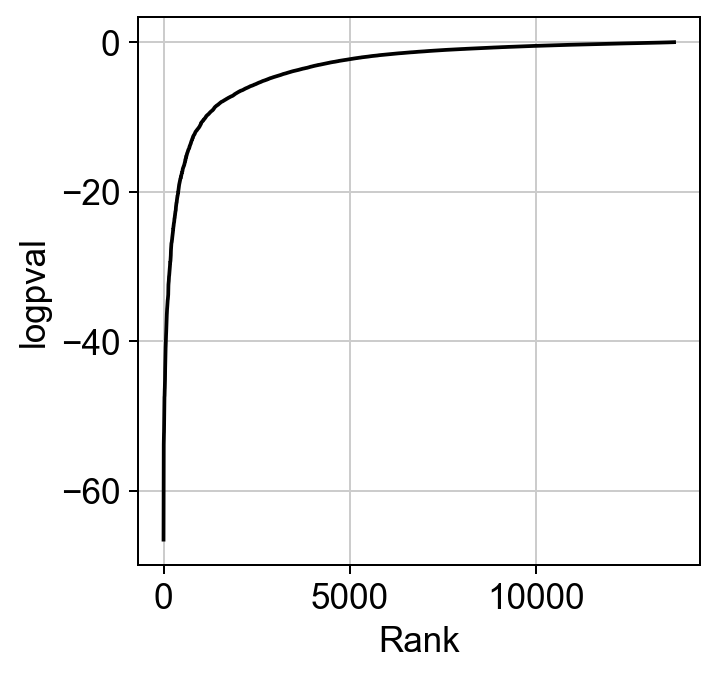

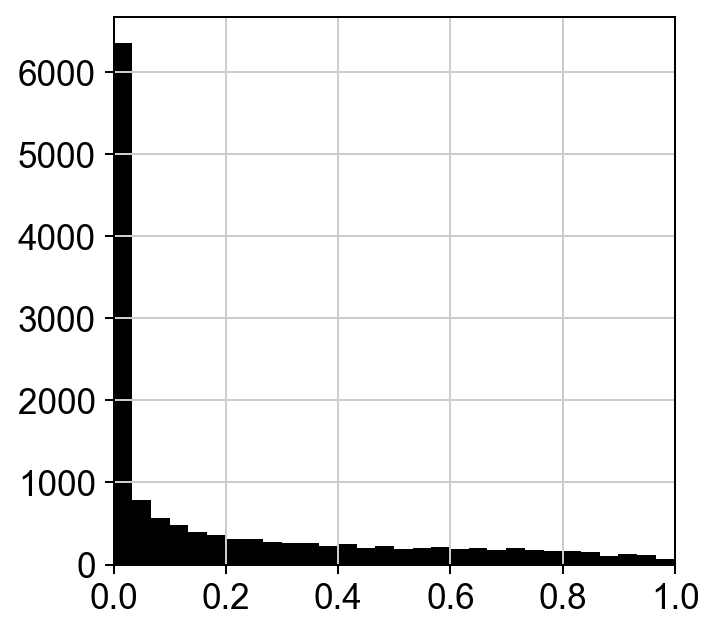

In [8]:
hs.plot_pval_rank(res)
hs.plot_pval_hist(res)

## Visualizing the results

A pandas DataFrame with the results can be obtained. By default the results are sorted by logpval_adj.

In [9]:
sum = res.top_features(n=10)
sum

,gene,KLD,pval,pval_adj,logpval,logpval_adj
9290,GZMB,0.004207,2.671463e-67,3.662041e-63,-66.573251,-62.436277
3200,FGFBP2,0.003713,2.990241e-63,4.099023e-59,-62.524294,-58.387320
7149,PRF1,0.002337,2.624538e-57,3.597716e-53,-56.580947,-52.443973
12799,CD79A,0.002090,1.626349e-56,2.229399e-52,-55.788786,-51.651812
1802,GNLY,0.002155,3.416672e-56,4.683574e-52,-55.466397,-51.329423
...,...,...,...,...,...,...
13172,A1BG-AS1,0.000098,9.969061e-01,1.000000e+00,-0.001346,0.000000
344,SYNC,0.000088,9.974878e-01,1.000000e+00,-0.001092,0.000000
1731,PCYOX1,0.000065,9.980668e-01,1.000000e+00,-0.000840,0.000000
13247,CRKL,0.000038,9.988439e-01,1.000000e+00,-0.000502,0.000000


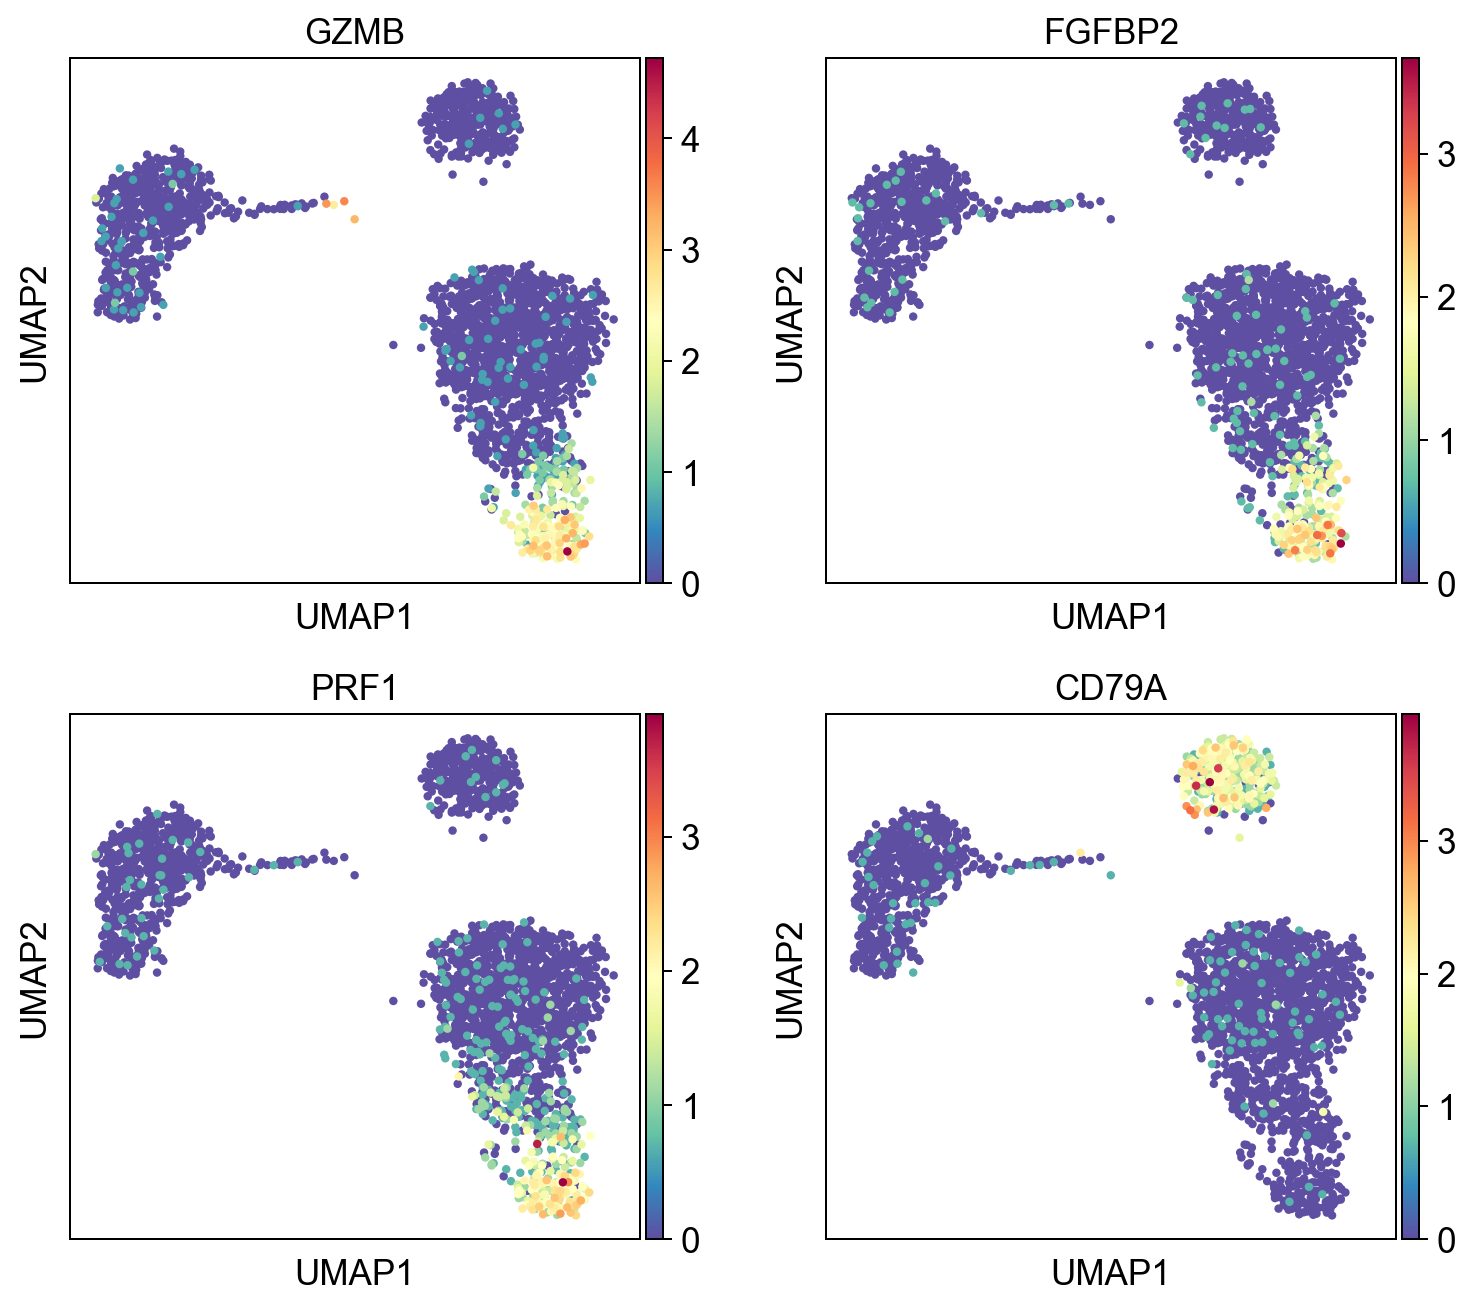

In [10]:
sc.pl.umap(adata, color=sum.gene.iloc[:4], ncols=2, cmap="Spectral_r")

## Clustering results into gene modules

We can cluster the results using K-means. We need to pass the `AnnData` object, the haystack results and the number of clusters.

In [11]:
gene_mods = hs.cluster_genes(adata.raw.to_adata(), res, n_clusters=4, random_state=1)
gene_mods.sort_values("cluster").groupby("cluster").head(3)

,gene,cluster
0,GZMB,0
48,CCL5,0
46,CTSW,0
63,CEBPD,1
64,SPI1,1
71,NCF2,1
3,CD79A,2
96,PKIG,2
11,HLA-DQA1,2
61,CD1C,3


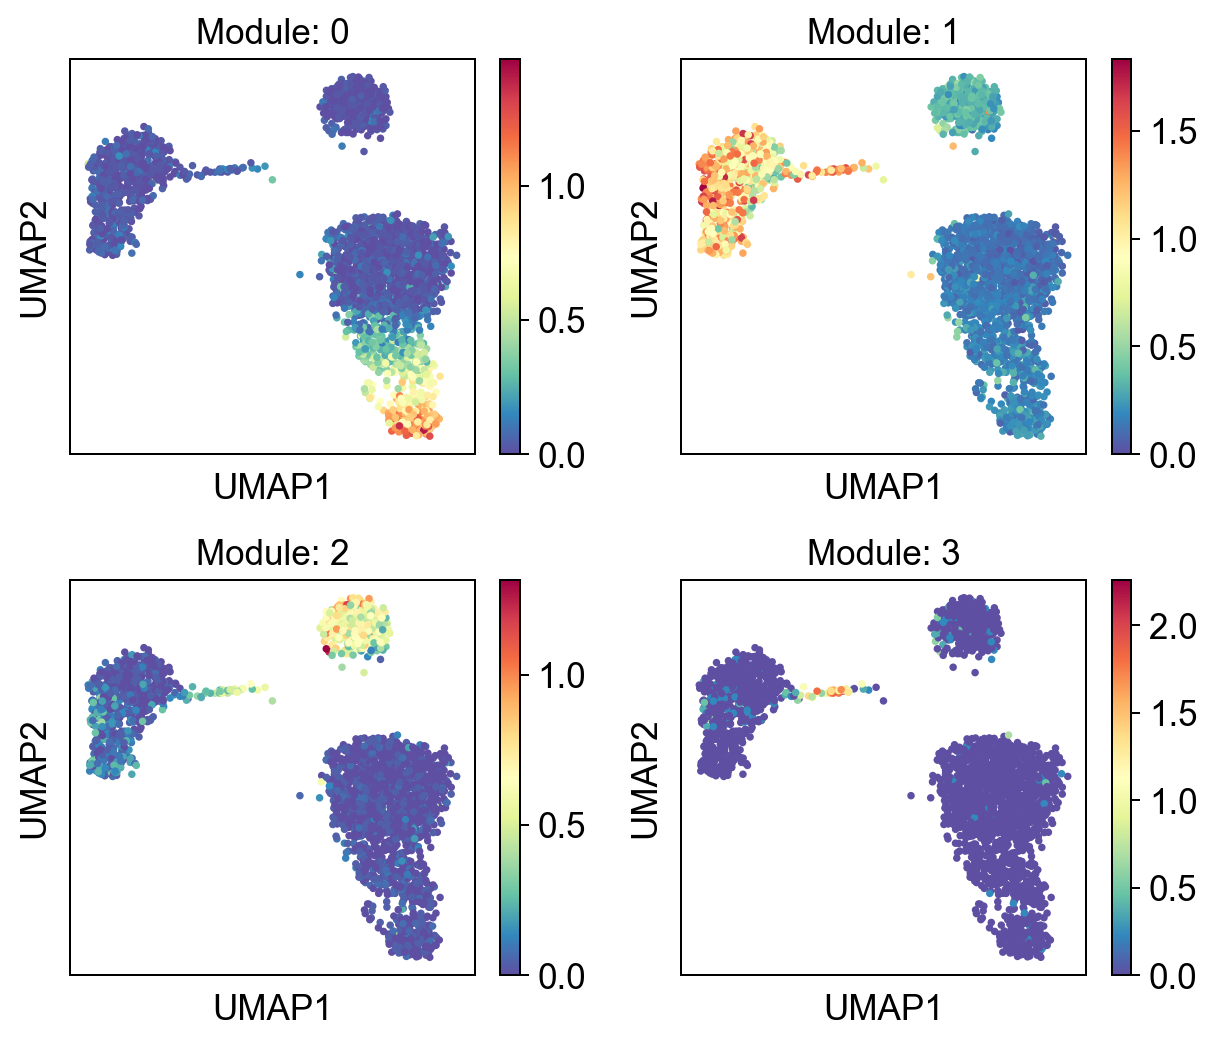

In [12]:
hs.plot_gene_clusters(adata.raw.to_adata(), gene_mods, basis="umap", ncols=2, figsize=[7, 6],   color_map="Spectral_r")

Check some of the genes in `Module 0`.

In [13]:
mod0 = gene_mods.groupby("cluster").get_group(0)
mod0.head(4)

,gene,cluster
0,GZMB,0
1,FGFBP2,0
2,PRF1,0
4,GNLY,0


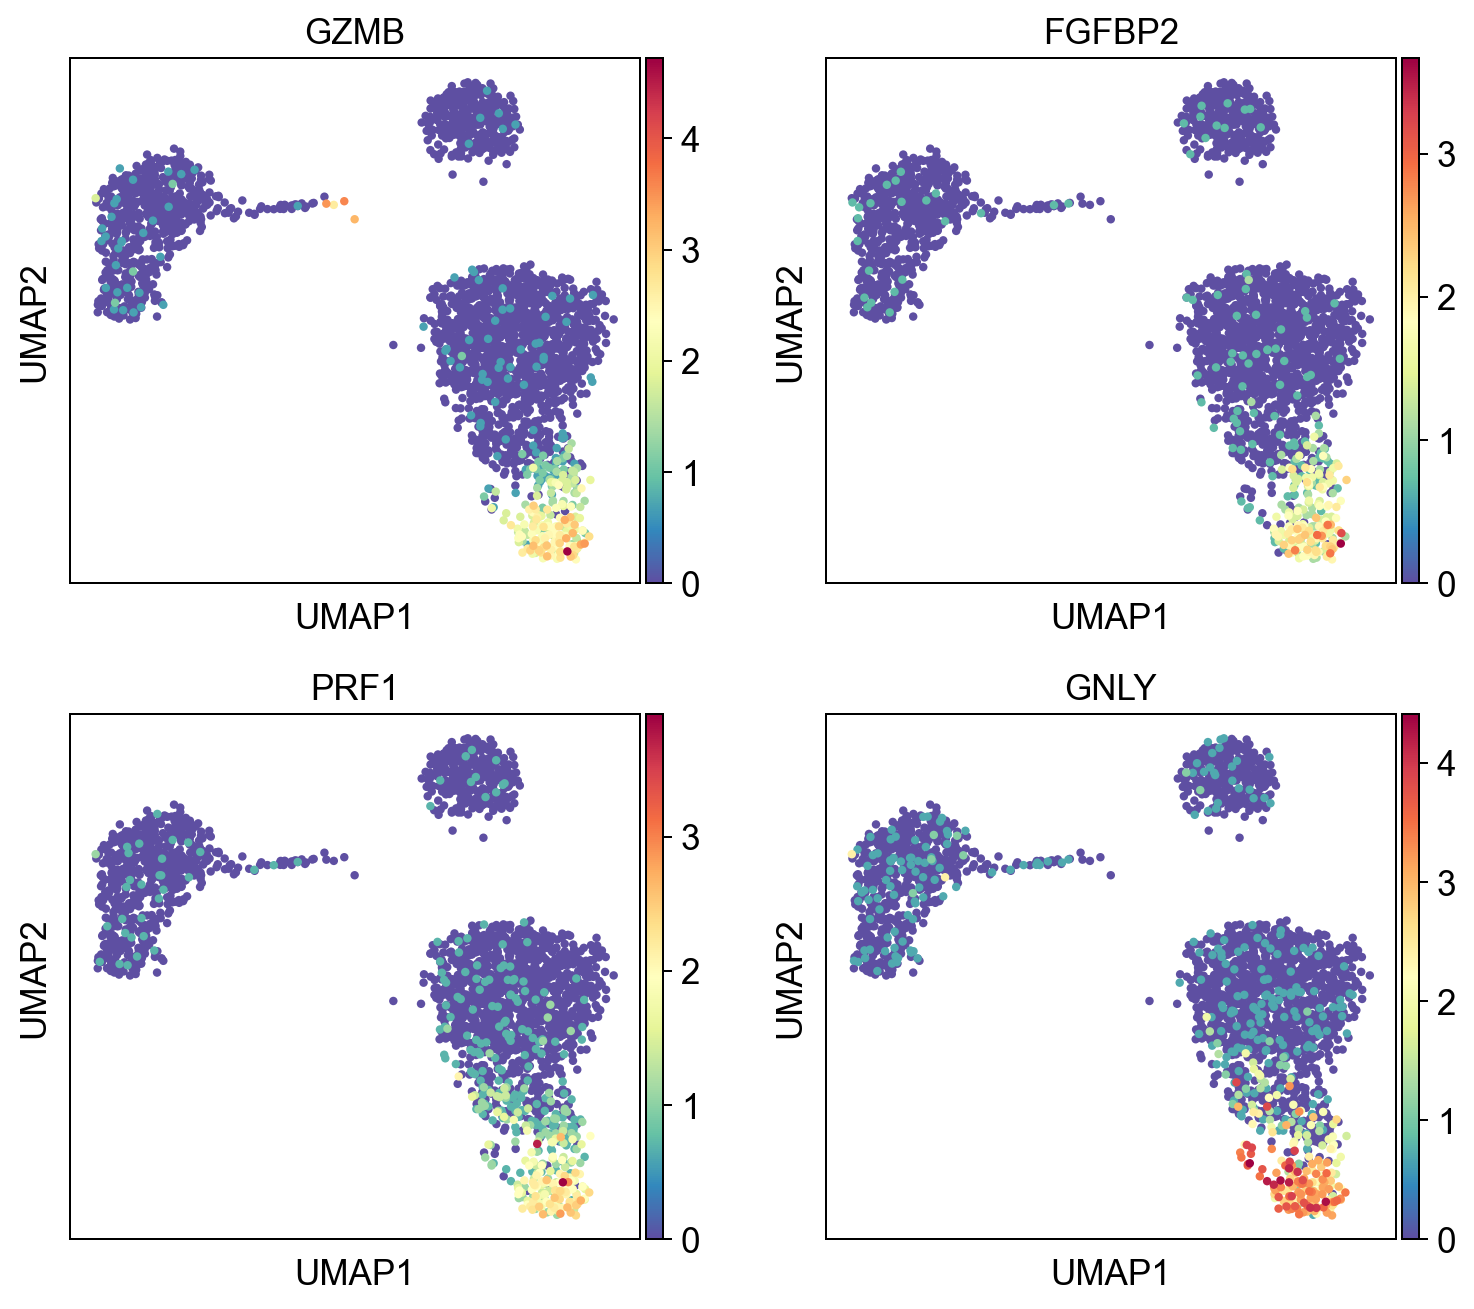

In [14]:
sc.pl.umap(adata, color=mod0.gene.iloc[:4], cmap="Spectral_r", ncols=2)

## Export results

In [15]:
#sum.to_csv("pbmc3k-results.tsv")